In [154]:
% load_ext autoreload
% aimport utils
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from utils import *
import matplotlib.pyplot as plt
import plotly.express as px

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%autoreload 1
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv',
           error_bad_lines=False)
cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',
                   error_bad_lines=False)
#cases['FIPS'] = cases['FIPS'].astype('int')
day_cases = get_day_cases()
counties = pd.read_csv('https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_data_abridged.csv',
                      error_bad_lines=False)
county_cases = pd.read_csv('https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_level/processed/nytimes_infections/nytimes_infections.csv',
                          error_bad_lines=False)

death_keep = [col+'_deaths' if (col in cases.columns and col != 'FIPS') else col for col in deaths.columns]
cases_keep = [col+'_cases' for col in cases.columns[12:]]
cases_and_deaths = cases.merge(deaths, on='FIPS', suffixes=('_cases', '_deaths'))[death_keep+cases_keep]
renamer = lambda name: name if (type(name) != str or '/' in name or '_deaths' not in name) else name[:-7]
cases_and_deaths = cases_and_deaths.rename(columns=renamer)
cases_and_deaths.head()

valid_territories = cases_and_deaths[(cases_and_deaths['Lat'] > 0) & ~np.isnan(cases_and_deaths['FIPS'])]
valid_territories.loc[:, 'FIPS'] = valid_territories['FIPS'].astype('int')
valid_counties = counties[~counties['countyFIPS'].isin(['City1', 'City2'])]
valid_counties.loc[:, 'countyFIPS'] = valid_counties['countyFIPS'].astype('int')

county_all = valid_counties.merge(valid_territories, left_on='countyFIPS', right_on='FIPS')
county_all = county_all.drop(columns=['Lat', 'Long_', 'Province_State', 'Country_Region', 'FIPS'])

C:\Users\2000s\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [3]:
day_cases[0].columns

Index(['Province_State', 'Country_Region', 'Last_Update', 'Lat', 'Long_',
       'Confirmed', 'Deaths', 'Recovered', 'Active', 'FIPS', 'Incident_Rate',
       'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'UID', 'ISO3',
       'Testing_Rate', 'Hospitalization_Rate'],
      dtype='object')

In [180]:
get_trait_ts = lambda terr, trait: [day_cases[day][trait][terr] for day in range(len(day_cases))]

def moving_average(a, n=4, ndim=1) :
    """
    From https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
    """
    if ndim == 2:
        return moving_average_2d(a, n=n)
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def moving_average_2d(a, n=7):
    ret = np.cumsum(a, axis=1, dtype=float)
    ret[:, n:] = ret[:, n:] - ret[:, :-n]
    return ret[:, n - 1:] / n

def featurize(dfs, features, n=4, target=30, day_buffer=5):
    """
    Given a list of column names, return a design matrix in the form a NumPy array.
    Note: time-series features are flattened so that we don't have to deal with tensor multiplication :)
    """
    num_per = min((target - day_buffer), len(dfs) - n + 1)
    design_matrix = np.zeros((50, (len(features))*num_per))
    for i in range(len(features)):
        for terr in range(50):
            avged_ts = moving_average(get_trait_ts(terr, features[i]), n=n)
            avged_ts = avged_ts[:target-day_buffer]
            design_matrix[terr, num_per*i:num_per*(i+1)] = avged_ts
    return design_matrix

def get_targets(dfs, feature, day, n=4):
    return np.array([moving_average(get_trait_ts(terr, feature), n=n)[day-n+1] for terr in range(50)])

def preprocess(dfs, features, n=4, day_buffer=5):
    design_matrix = featurize(dfs, features, n=n, day_buffer=day_buffer)
    return design_matrix

In [184]:
cd = preprocess(day_cases, ['Confirmed', 'Deaths', 'Recovered', 'People_Tested'], n=4, day_buffer=0)
goals = get_targets(day_cases, 'Mortality_Rate', 30)

In [185]:
cd.shape

(50, 112)

In [186]:
lr = LinearRegression(fit_intercept=True)
scores = cross_val_score(lr, cd, goals, cv=5, scoring='r2')

In [187]:
scores

array([-317.77074007,  -19.73553   ,   -4.81334683, -169.59467641,
        -24.55009569])

In [5]:
day_cases[1]

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-13 23:07:54,32.3182,-86.9023,3734,99,NaN,3635.0,1.0,79.634933,29182.0,457.0,2.651312,84000001,USA,622.363852,12.238886
1,Alaska,US,2020-04-13 23:07:54,61.3707,-152.4044,277,8,85.0,269.0,2.0,46.340521,7830.0,32.0,2.888087,84000002,USA,1309.914362,11.552347
2,Arizona,US,2020-04-13 23:07:54,33.7298,-111.4312,3705,122,NaN,3583.0,4.0,50.901828,43347.0,525.0,3.292848,84000004,USA,595.530778,14.170040
3,Arkansas,US,2020-04-13 23:07:54,34.9697,-92.3731,1410,29,391.0,1381.0,5.0,54.460614,20804.0,130.0,2.056738,84000005,USA,803.545116,9.219858
4,California,US,2020-04-13 23:07:54,36.1162,-119.6816,23931,714,NaN,23217.0,6.0,61.035048,190882.0,3015.0,2.987756,84000006,USA,486.836823,12.598721
5,Colorado,US,2020-04-13 23:07:54,39.0598,-105.3111,7691,306,NaN,7385.0,8.0,135.720025,37534.0,1472.0,3.978676,84000008,USA,662.347602,19.139254
6,Connecticut,US,2020-04-13 23:07:54,41.5978,-72.7554,13381,602,NaN,12779.0,9.0,375.313404,44309.0,1760.0,4.498916,84000009,USA,1242.789150,13.152978
7,Delaware,US,2020-04-13 23:07:54,39.3185,-75.5071,1758,41,213.0,1717.0,10.0,180.536557,11820.0,201.0,2.332196,84000010,USA,1213.846476,11.433447
8,Florida,US,2020-04-14 00:42:00,27.7663,-81.6868,21019,499,NaN,122520.0,12.0,579.387193,196207.0,2833.0,0.405628,84000012,USA,924.083459,2.302896
9,Georgia,US,2020-04-13 23:07:54,33.0406,-83.6431,13315,465,NaN,12850.0,13.0,131.319498,57021.0,2589.0,3.492302,84000013,USA,562.370943,19.444236


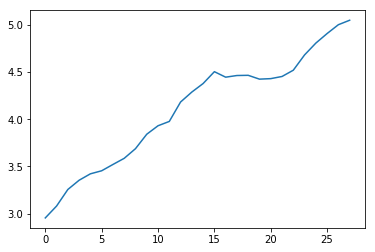

In [33]:
plt.plot(moving_average(mort_rates[24]))

In [6]:
get_trait_ts(2, 'Mortality_Rate')

[3.246753247,
 3.292847503373819,
 3.439222893,
 3.5822401614530777,
 3.5402407363700727,
 3.746397694524496,
 3.8103302286198137,
 3.729981755524022,
 3.768745067087608,
 3.9573820395738197,
 4.220719897679517,
 4.3139293139293144,
 4.400330851943755,
 4.342984409799555,
 4.2087542087542085,
 4.089219330855019,
 3.9539899352983454,
 4.2724372312387295,
 4.18027433050294,
 4.141046555402183,
 3.9454806312769013,
 4.189814814814815,
 4.056476916181085,
 4.2450295540032235,
 4.38858555681467,
 4.524886877828054,
 4.911647349420481,
 4.854014598540147,
 4.820577390053061,
 4.761486427128173,
 4.788684389911384]

In [19]:
day_cases[0]

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3470,93,3470,3470,1.0,75.988020,21583.0,437.0,2.610160,84000001,USA,460.300152,12.264945
1,Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,264,8,264,264,2.0,45.504049,8038.0,31.0,2.941176,84000002,USA,1344.711576,11.397059
2,Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3427,115,3427,3427,4.0,48.662422,42109.0,NaN,3.246753,84000004,USA,578.522286,NaN
3,Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1253,27,1253,1253,5.0,49.439423,19722.0,130.0,2.109375,84000005,USA,761.753354,10.156250
4,California,US,2020-04-12 23:18:15,36.1162,-119.6816,22155,640,22155,22155,6.0,58.137726,190328.0,5234.0,2.812020,84000006,USA,485.423868,22.961176
5,Colorado,US,2020-04-12 23:18:15,39.0598,-105.3111,7018,289,7018,7018,8.0,128.943729,34873.0,1376.0,3.955112,84000008,USA,615.389991,18.831258
6,Connecticut,US,2020-04-12 23:18:15,41.5978,-72.7554,11481,554,11481,11481,9.0,337.560483,41220.0,1654.0,4.603241,84000009,USA,1156.148159,13.743249
7,Delaware,US,2020-04-12 23:18:15,39.3185,-75.5071,1590,35,1590,1590,10.0,166.878217,11103.0,190.0,2.153846,84000010,USA,1140.214672,11.692308
8,Florida,US,2020-04-12 23:18:15,27.7663,-81.6868,19434,461,19434,19434,12.0,93.700227,182753.0,2772.0,2.317165,84000012,USA,860.718651,13.933149
9,Georgia,US,2020-04-12 23:18:15,33.0406,-83.6431,12019,433,12019,12019,13.0,122.808141,54453.0,2505.0,3.477353,84000013,USA,537.043983,20.117250


In [150]:
[np.isnan(day_cases[i]['People_Tested']).sum() for i in range(len(day_cases))]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [25]:
mort_rates = np.zeros((50, len(day_cases)))
for terr in range(50):
    mort_rates[terr, :] = get_trait_ts(terr, 'Mortality_Rate')

In [8]:
mort_rates

array([[2.61015998, 2.65131227, 2.88388566, ..., 3.97411265, 3.96497442,
        4.15711009],
       [2.94117647, 2.88808664, 3.15789474, ..., 2.63852243, 2.63852243,
        2.61096606],
       [3.24675325,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [2.06916721, 0.69124424, 0.60728745, ..., 0.96673301, 0.94078583,
        1.06470106],
       [0.78158923, 1.942959  , 2.12802471, ..., 1.62162162, 1.61477097,
        1.65104587],
       [3.71389271, 2.13660245, 2.27908836, ..., 2.78669316, 2.75428431,
        2.76597799]])

In [7]:
# Do some PCA to see if there are distinct clusters of behavior
# Apparently there are not.
mort_rates_centered = mort_rates - mort_rates.mean(axis=0)
pca = PCA(n_components=2)
pairs = pca.fit_transform(mort_rates_centered)
px.scatter(pairs[:, 0], pairs[:, 1], hover_name=day_cases[0]['Province_State'])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Choosing a day to split on

We progressively step through the days and test them to see which has the highest variance in mortality rates. We find that the 30th day in the set of dataframes, corresponding to 

In [89]:
# Choosing which day to split on: take the day with highest variance in mora
max_var_day = np.argmax([np.std(mort_rates[:, i]) for i in range(mort_rates.shape[1])])
max_var_day

30

array([0.93976454, 0.04416661])